In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


https://drive.google.com/drive/folders/1J3T57sSD-qIRUGOK3yANMe8_PHSW5hWC?usp=sharing

Load the dataset into your drive to run the following model

In [2]:
!unzip /content/drive/MyDrive/NeuralNetwork_GenderClassification/dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/4_M/11024_25_male.jpg  
  inflating: dataset/train/4_M/1103_25_male.jpg  
  inflating: dataset/train/4_M/11052_25_male.jpg  
  inflating: dataset/train/4_M/11073_25_male.jpg  
  inflating: dataset/train/4_M/11088_25_male.jpg  
  inflating: dataset/train/4_M/11090_25_male.jpg  
  inflating: dataset/train/4_M/111_25_male.jpg  
  inflating: dataset/train/4_M/1110_25_male.jpg  
  inflating: dataset/train/4_M/11110_25_male.jpg  
  inflating: dataset/train/4_M/11115_25_male.jpg  
  inflating: dataset/train/4_M/11116_25_male.jpg  
  inflating: dataset/train/4_M/1112_25_male.jpg  
  inflating: dataset/train/4_M/11120_25_male.jpg  
  inflating: dataset/train/4_M/11121_25_male.jpg  
  inflating: dataset/train/4_M/11123_25_male.jpg  
  inflating: dataset/train/4_M/11135_25_male.jpg  
  inflating: dataset/train/4_M/112_25_male.jpg  
  inflating: dataset/train/4_M/1126_25_male.jpg  
  inflating: dataset/train/4_M/1127_25_

In [61]:
import os

import numpy as np
import sklearn as sk

import os
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [62]:
datagen = ImageDataGenerator(
    rotation_range=40,            # Random rotations within the range of 0 to 40 degrees
    width_shift_range=0.2,       # Random horizontal shifts up to 20% of image width
    height_shift_range=0.2,      # Random vertical shifts up to 20% of image height
    shear_range=0.2,             # Shear angle in counter-clockwise direction as radians
    zoom_range=0.2,              # Randomly zoom in/out within the range [1 - 0.2, 1 + 0.2]
    horizontal_flip=True,        # Randomly flip inputs horizontally
    fill_mode='nearest',         # Fill points outside the input boundaries with the 'nearest' value they're to
    brightness_range=[0.2,1.2],  # Randomly change brightness within the range [0.2, 1.2]
    rescale=1./255               # Normalize pixel values to [0, 1]
)

Data Preprocessing

Found 13232 images belonging to 16 classes.
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


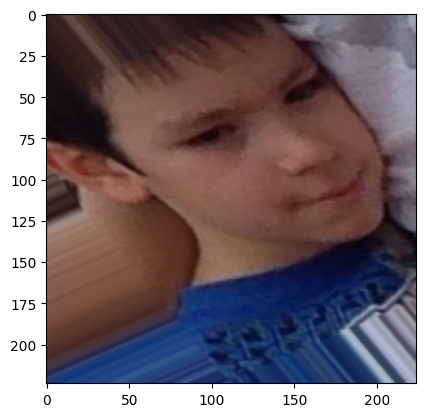

In [63]:
# Show an image example
base_dir = "/content/"
train_dir_age = os.path.join(base_dir, 'dataset','train')

train_generator_age = datagen.flow_from_directory(
    train_dir_age,
    target_size=(224, 224),  # adjust this if your image size is different
    batch_size=32,          # batch size can be adjusted based on your needs
    class_mode='categorical'
)

# Get a batch of augmented images
images, labels = next(train_generator_age)
print(labels[1])

# Display
plt.imshow(images[1])
plt.show()


In [64]:
base_dir = "/content/dataset"
train_dir_age_gender = os.path.join(base_dir, 'train')
test_dir_age_gender = os.path.join(base_dir, 'test')

# Transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224,224)), # Resize
    # transforms.Grayscale(),
    transforms.ToTensor(),

])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.Grayscale(),
    transforms.ToTensor(),

])

# Datasets using ImageFolder
trainset = datasets.ImageFolder(root=train_dir_age_gender, transform=train_transform)
testset = datasets.ImageFolder(root=test_dir_age_gender, transform=test_transform)


# DataLoaders
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [7]:
dataset=trainloader.dataset
print((dataset.class_to_idx))
print(len(dataset.classes))

idx_to_class ={}
for key,value in dataset.class_to_idx.items():
    idx_to_class[value]=key

print(idx_to_class)

{'0_F': 0, '0_M': 1, '1_F': 2, '1_M': 3, '2_F': 4, '2_M': 5, '3_F': 6, '3_M': 7, '4_F': 8, '4_M': 9, '5_F': 10, '5_M': 11, '6_F': 12, '6_M': 13, '7_F': 14, '7_M': 15}
16
{0: '0_F', 1: '0_M', 2: '1_F', 3: '1_M', 4: '2_F', 5: '2_M', 6: '3_F', 7: '3_M', 8: '4_F', 9: '4_M', 10: '5_F', 11: '5_M', 12: '6_F', 13: '6_M', 14: '7_F', 15: '7_M'}


In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import seaborn as sns
import numpy as np
from torch.utils.data import random_split

import cv2

# device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
!pip install torchfile
import torchfile

  Preparing metadata (setup.py) ... done
  Created wheel for torchfile: filename=torchfile-0.1.0-py3-none-any.whl size=5694 sha256=c190d1e1f002f4d2d00ea94a26f5e4bac88a9f876d05c587951a84ae53b993d0
  Stored in directory: /root/.cache/pip/wheels/c7/e9/87/1c51daf8e468d5c14931f8ac3344880f903ba96b063675cac2
Successfully built torchfile


View Single Batch

images.shape: torch.Size([16, 3, 224, 224])
['1_M', '3_F', '1_F', '7_M', '1_M', '5_M', '6_F', '2_F', '6_F', '2_M', '2_F', '2_M', '4_F', '4_F', '5_M', '7_M']


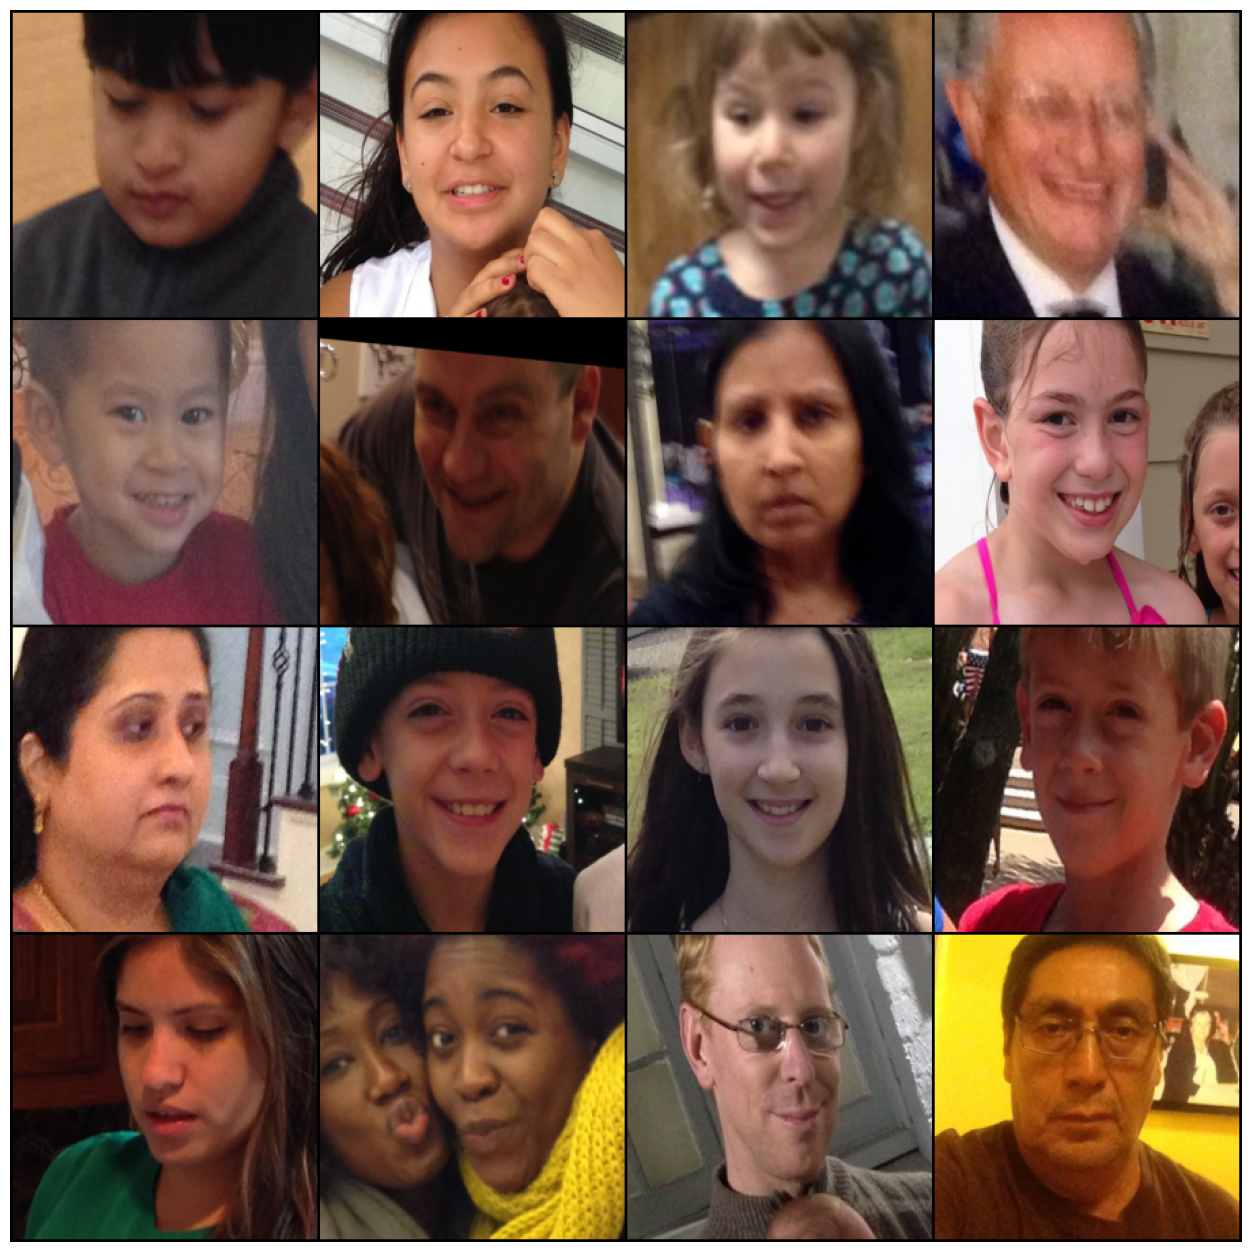

In [66]:
from torchvision.utils import make_grid
for images, labels in trainloader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,16))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=4).permute((1, 2, 0)))
    break

string_labels = [idx_to_class[int(i)] for i in labels]
print(string_labels)

# Transfer Learning (Loading pretrained weights from VGG16)

In [67]:


class VGG_16(nn.Module):

    def __init__(self):
        super().__init__()
        self.block_size = [2, 2, 3, 3, 3]
        self.conv_1_1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.conv_1_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv_2_1 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv_2_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv_3_1 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv_3_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv_3_3 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv_4_1 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.conv_4_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_4_3 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_1 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_3 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.fc6 = nn.Linear(512 * 7 * 7, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, 2622)

    def load_weights(self, path="/content/drive/MyDrive/NeuralNetwork_GenderClassification/vgg_face_torch/VGG_FACE.t7"):
        """ Function to load luatorch pretrained

        Args:
            path: path for the luatorch pretrained
        """
        model = torchfile.load(path)
        counter = 1
        block = 1
        for i, layer in enumerate(model.modules):
            if layer.weight is not None:
                if block <= 5:
                    self_layer = getattr(self, "conv_%d_%d" % (block, counter))
                    counter += 1
                    if counter > self.block_size[block - 1]:
                        counter = 1
                        block += 1
                    self_layer.weight.data[...] = torch.tensor(layer.weight).view_as(self_layer.weight)[...]
                    self_layer.bias.data[...] = torch.tensor(layer.bias).view_as(self_layer.bias)[...]
                else:
                    self_layer = getattr(self, "fc%d" % (block))
                    block += 1
                    self_layer.weight.data[...] = torch.tensor(layer.weight).view_as(self_layer.weight)[...]
                    self_layer.bias.data[...] = torch.tensor(layer.bias).view_as(self_layer.bias)[...]

    def forward(self, x):
        """ Pytorch forward

        Args:
            x: input image (224x224)

        Returns: class logits

        """
        x = F.relu(self.conv_1_1(x))
        x = F.relu(self.conv_1_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2_1(x))
        x = F.relu(self.conv_2_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_3_1(x))
        x = F.relu(self.conv_3_2(x))
        x = F.relu(self.conv_3_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_4_1(x))
        x = F.relu(self.conv_4_2(x))
        x = F.relu(self.conv_4_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_5_1(x))
        x = F.relu(self.conv_5_2(x))
        x = F.relu(self.conv_5_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc6(x))
        x = F.dropout(x, 0.5, self.training)
        return x
        # x = F.relu(self.fc7(x))
        # x = F.dropout(x, 0.5, self.training)
        # return self.fc8(x)



In [68]:
model = VGG_16().float()
model.load_weights()



In [69]:
class age_model(nn.Module):
    def __init__(self):
        super(age_model, self).__init__()
        self.fc_age1 = nn.Linear(4096,4096)
        self.fc_age2 =nn.Linear(4096,2048)
        self.fc_age3 = nn.Linear(2048, 8) #Classification problem
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x= x = F.relu(self.fc_age1(x))
        x = F.dropout(x, 0.5, self.training)
        x = F.relu(self.fc_age2(x))
        x = F.dropout(x, 0.5, self.training)
        x = self.fc_age3(x)  # Age prediction
        # x = self.softmax(x)

        return x

class gender_model(nn.Module):
    def __init__(self):
        super(gender_model, self).__init__()
        self.fc_gender1 =nn.Linear(4096,4096)
        self.fc_gender2 = nn.Linear(4096,2048)
        self.fc_gender3=nn.Linear(2048, 1) #Classification problem
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.fc_gender1(x))
        x = F.dropout(x, 0.5, self.training)
        x = F.relu(self.fc_gender2(x))
        x = F.dropout(x, 0.5, self.training)
        x = self.fc_gender3(x)  # Gender prediction
        x = self.sigmoid(x)
        return x

In [70]:
age_model = age_model()
gender_model=gender_model()

age_model = age_model.to('cuda')
gender_model = gender_model.to('cuda')

# Test Pretrained Model

In [71]:
im = cv2.imread("/content/drive/MyDrive/NeuralNetwork_GenderClassification/vgg_face_torch/ak.png")
im = torch.Tensor(im).permute(2, 0, 1).view(1, 3, 224, 224).float()
import numpy as np

model.eval()
im -= torch.Tensor(np.array([129.1863, 104.7624, 93.5940])).float().view(1, 3, 1, 1)
preds = F.softmax(model(im), dim=1)
values, indices = preds.max(-1)
print(indices)

tensor([3738])


# Freeze layers and replace classification layers

In [72]:
for param in model.parameters():
  param.requires_grad=False



Seperate age_gender label into age and gender 

In [29]:

CLASSES= trainloader.dataset.classes

unique_age_classes = set()
unique_gender_classes = set()

# Iterate through the labels to extract age and gender information
for label in CLASSES:
    age,gender = label.split("_")
    unique_age_classes.add(age)
    unique_gender_classes.add(gender)

# Calculate the number of unique age and gender classes
num_age_classes = len(unique_age_classes)
num_gender_classes = len(unique_gender_classes)

print("Number of unique age classes:", num_age_classes)
print("Number of unique gender classes:", num_gender_classes)


# model.fc8 = nn. Linear(4096, 2)

Number of unique age classes: 8
Number of unique gender classes: 2


In [ ]:
Model Parameter

In [73]:
from torchsummary import summary
model = model.to('cuda')
# Replace 'model' with your model object
summary(model,(3,224,224))  # Assumes an input shape of (3, 224, 224)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]          36,928
            Conv2d-3        [-1, 128, 112, 112]          73,856
            Conv2d-4        [-1, 128, 112, 112]         147,584
            Conv2d-5          [-1, 256, 56, 56]         295,168
            Conv2d-6          [-1, 256, 56, 56]         590,080
            Conv2d-7          [-1, 256, 56, 56]         590,080
            Conv2d-8          [-1, 512, 28, 28]       1,180,160
            Conv2d-9          [-1, 512, 28, 28]       2,359,808
           Conv2d-10          [-1, 512, 28, 28]       2,359,808
           Conv2d-11          [-1, 512, 14, 14]       2,359,808
           Conv2d-12          [-1, 512, 14, 14]       2,359,808
           Conv2d-13          [-1, 512, 14, 14]       2,359,808
           Linear-14                 [-

In [74]:

lr=1e-3
gender_criterion = nn.BCELoss()
gender_optimizer = torch.optim.Adam(gender_model.parameters(), lr= lr)

age_criterion = nn.CrossEntropyLoss()
age_optimizer = torch.optim.Adam(age_model.parameters(), lr= lr)

In [31]:

class_to_index = trainloader.dataset.class_to_idx

for idx, (images, labels) in enumerate(trainloader):
  # Map indices to class labels using the class-to-index dictionary
  class_labels = [key for value in labels for key, index in class_to_index.items() if index == value]
  age_labels = []
  gender_labels = []

  for label in class_labels:
      age, gender = label.split('_')
      age_labels.append(int(age))
      gender_labels.append(0 if gender == 'M' else 1)

  print(class_labels)
  print(age_labels)
  print(gender_labels)
  break

['5_F', '1_M', '2_F', '0_M', '0_M', '4_M', '4_F', '4_F', '0_M', '4_F', '4_F', '1_F', '1_F', '6_M', '5_M', '1_M']
[5, 1, 2, 0, 0, 4, 4, 4, 0, 4, 4, 1, 1, 6, 5, 1]
[1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0]


Training Loop (STOPPED AT EPOCH 16)

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

class_to_index = trainloader.dataset.class_to_idx


num_epochs=30

loss_age_train=[]
loss_age_val = []

loss_gender_train = []
loss_gender_val = []

acc_gender_train = []
acc_gender_val = []

acc_age_train = []
acc_age_val = []

for epoch in range(num_epochs):
    loss_var_age = 0
    loss_var_gender = 0

    correct_gender=0
    samples_gender=0

    correct_age=0
    samples_age=0

    for idx, (images, labels) in enumerate(trainloader):


        ####################################### Splitting Label ###########################################
        class_labels = [key for value in labels for key, index in class_to_index.items() if index == value]
        age_labels = []
        gender_labels = []

        for label in class_labels:
            age, gender = label.split('_')
            age_labels.append(int(age))
            gender_labels.append(0 if gender == 'M' else 1) #Male: 0 Female: 1


        # Convert age_labels and gender_labels to PyTorch tensors
        age_labels = torch.tensor(age_labels, dtype=torch.long)
        gender_labels= torch.tensor(gender_labels, dtype=torch.float32)

        images = images.to(device=device)
        age_labels = age_labels.to(device=device)
        gender_labels = gender_labels.to(device=device)

        ###################################################################################################


        # Forward Pass
        gender_optimizer.zero_grad()
        age_optimizer.zero_grad()

        model.train()
        age_model.train()
        gender_model.train()

        x = model(images)
        age_pred = age_model(x)
        gender_pred=gender_model(x).squeeze()


        age_loss = age_criterion(age_pred,age_labels)
        gender_loss = gender_criterion(gender_pred,gender_labels)

        age_loss.backward()
        gender_loss.backward()

        age_optimizer.step()
        gender_optimizer.step()

        loss_var_age += age_loss.item()
        loss_var_gender += gender_loss.item()

        correct_gender+= (gender_pred.round() == gender_labels).sum()
        samples_gender+=gender_pred.size(0)

        age_pred_class = F.softmax(age_pred,dim=1)
        _, age_pred_class = torch.max(age_pred_class, 1)

        correct_age+= (age_pred_class == age_labels).sum()
        samples_age+=age_pred.size(0)
        if idx%99==0:
            print(f'Epoch [{epoch+1}/{num_epochs}] || Step [{idx+1}/{len(trainloader)}] || Age Loss:{loss_var_age/len(trainloader)} || Gender Loss:{loss_var_gender/len(trainloader)}')

    loss_age_train.append(loss_var_age/len(trainloader))
    loss_gender_train.append(loss_var_gender/len(trainloader))
    acc_gender_train.append(float(correct_gender) / float(samples_gender))

    acc_age_train.append(float(correct_age) / float(samples_age))
    print(f"Loss at epoch {epoch+1} || Age Loss:{loss_var_age/len(trainloader)} || Gender Loss:{loss_var_gender/len(trainloader)} || Age Accuracy: {float(correct_age) / float(samples_age)} || Gender Accuracy: {float(correct_gender) / float(samples_gender)} ")
    torch.save(age_model.state_dict(), f'/content/drive/MyDrive/NeuralNetwork_GenderClassification/Weights/age_model_weights_epoch_{epoch + 1}.pt')
    torch.save(gender_model.state_dict(), f'/content/drive/MyDrive/NeuralNetwork_GenderClassification/Weights/gender_model_weights_epoch_{epoch + 1}.pt')

    model.eval()
    age_model.eval()
    gender_model.eval()
    with torch.no_grad():
        loss_var_age = 0
        loss_var_gender = 0
        correct_gender = 0
        samples_gender =0
        correct_age=0
        samples_age =0
        for idx, (images, labels) in enumerate(testloader):

            ####################################### Splitting Label ###########################################
            class_labels = [key for value in labels for key, index in class_to_index.items() if index == value]
            age_labels = []
            gender_labels = []

            for label in class_labels:
                age, gender = label.split('_')
                age_labels.append(int(age))
                gender_labels.append(0 if gender == 'M' else 1) #Male: 0 Female: 1


            # Convert age_labels and gender_labels to PyTorch tensors
            age_labels = torch.tensor(age_labels, dtype=torch.long)
            gender_labels= torch.tensor(gender_labels, dtype=torch.float32)

            images = images.to(device=device)
            age_labels = age_labels.to(device=device)
            gender_labels = gender_labels.to(device=device)

            ###################################################################################################

            #Calculate Validation Loss, Accuracy of Gender  and Validation Loss of Age

            # Forward Pass

            x = model(images)
            age_pred = age_model(x)
            gender_pred =gender_model(x).squeeze()


            age_loss = age_criterion(age_pred,age_labels)
            gender_loss = gender_criterion(gender_pred,gender_labels)

            loss_var_age += age_loss.item()
            loss_var_gender += gender_loss.item()

            correct_gender+= (gender_pred.round() == gender_labels).sum()
            samples_gender+=gender_pred.size(0)

            age_pred_class = F.softmax(age_pred,dim=1)
            _, age_pred_class = torch.max(age_pred_class, 1)

            correct_age+= (age_pred_class == age_labels).sum()
            samples_age+=age_pred.size(0)


        loss_age_val.append(loss_var_age/len(testloader))
        loss_gender_val.append(loss_var_gender/len(testloader))
        acc_gender_val.append(float(correct_gender) / float(samples_gender))
        acc_age_val.append(float(correct_age) / float(samples_age))

        print(f"Validation at epoch {epoch+1} || Age Loss:{loss_var_age/len(testloader)} || Gender Loss:{loss_var_gender/len(testloader)} || Age Accuracy: {float(correct_age) / float(samples_age)} |||| Gender Accuracy: {float(correct_gender) / float(samples_gender)} ")


Epoch [1/30] || Step [1/827] || Age Loss:0.0009160174424011156 || Gender Loss:0.00032705533461242087
Epoch [1/30] || Step [100/827] || Age Loss:0.13091589180705338 || Gender Loss:0.0366308775853181
Epoch [1/30] || Step [199/827] || Age Loss:0.25011756295448634 || Gender Loss:0.07487380494472842
Epoch [1/30] || Step [298/827] || Age Loss:0.3667998175162646 || Gender Loss:0.10436359729883604
Epoch [1/30] || Step [397/827] || Age Loss:0.48016120697019177 || Gender Loss:0.13809123637544346
Epoch [1/30] || Step [496/827] || Age Loss:0.5925004441547855 || Gender Loss:0.1695582490986463
Epoch [1/30] || Step [595/827] || Age Loss:0.703135021039912 || Gender Loss:0.19891979941082477
Epoch [1/30] || Step [694/827] || Age Loss:0.8161349358552888 || Gender Loss:0.224652940265501
Epoch [1/30] || Step [793/827] || Age Loss:0.9215842262360897 || Gender Loss:0.2543441758839078
Loss at epoch 1 || Age Loss:0.9545704261135162 || Gender Loss:0.2641608126578625 || Age Accuracy: 0.6345223700120919 || Gender

KeyboardInterrupt: ignored

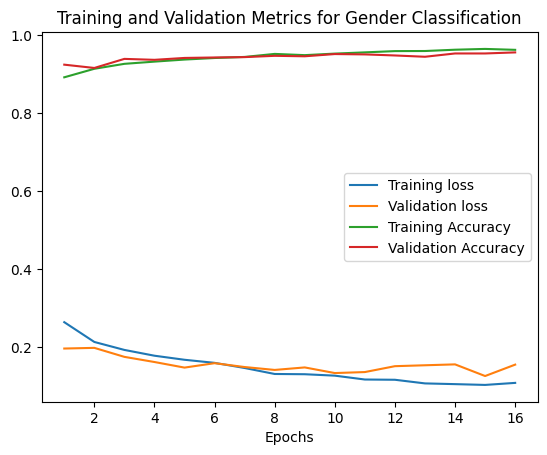

In [80]:
import matplotlib.pyplot as plt


epoch_range = [i for i in range(1,16+1)]
# plot training and validation loss, and f1 score
plt.plot(epoch_range,loss_gender_train, label='Training loss')
plt.plot(epoch_range,loss_gender_val, label='Validation loss')
plt.plot(epoch_range,acc_gender_train, label='Training Accuracy')
plt.plot(epoch_range,acc_gender_val, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.title('Training and Validation Metrics for Gender Classification')
plt.show()

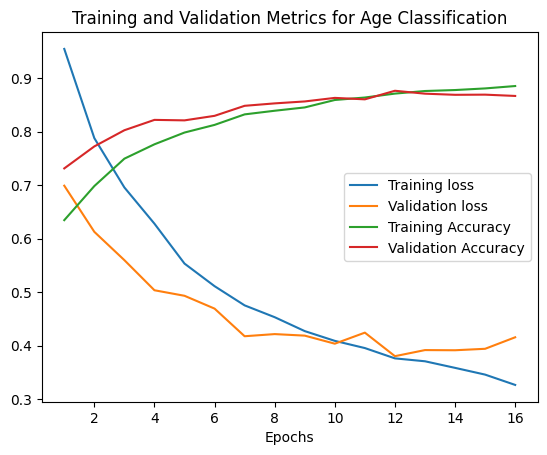

In [81]:


# plot training and validation loss, and f1 score
plt.plot(epoch_range,loss_age_train, label='Training loss')
plt.plot(epoch_range,loss_age_val, label='Validation loss')
plt.plot(epoch_range,acc_age_train, label='Training Accuracy')
plt.plot(epoch_range,acc_age_val, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.title('Training and Validation Metrics for Age Classification')
plt.show()

In [106]:
from sklearn.metrics import f1_score, precision_score, recall_score

model.eval()
age_model.eval()
gender_model.eval()
with torch.no_grad():
    f1_age=0
    f1_gender=0
    precision_age=0
    precision_gender=0
    recall_gender=0
    recall_age=0
    for idx, (images, labels) in enumerate(testloader):

        ####################################### Splitting Label ###########################################
        class_labels = [key for value in labels for key, index in class_to_index.items() if index == value]
        age_labels = []
        gender_labels = []

        for label in class_labels:
            age, gender = label.split('_')
            age_labels.append(int(age))
            gender_labels.append(0 if gender == 'M' else 1) #Male: 0 Female: 1


        # Convert age_labels and gender_labels to PyTorch tensors
        age_labels = torch.tensor(age_labels, dtype=torch.long)
        gender_labels= torch.tensor(gender_labels, dtype=torch.float32)

        images = images.to(device=device)
        age_labels = age_labels.to(device=device)
        gender_labels = gender_labels.to(device=device)

        ###################################################################################################

        #Calculate Validation Loss, Accuracy of Gender  and Validation Loss of Age

        # Forward Pass

        x = model(images)
        age_pred = age_model(x)
        gender_pred =gender_model(x).squeeze().round()

        age_pred = F.softmax(age_pred,dim=1)
        _, age_pred = torch.max(age_pred, 1)


        age_labels = age_labels.cpu().numpy().flatten()
        gender_labels = gender_labels.cpu().numpy().flatten()
        age_pred = age_pred.cpu().numpy().flatten()
        gender_pred = gender_pred.cpu().numpy().flatten()


        f1_age+=f1_score(age_pred,age_labels,average='weighted',zero_division=1)
        f1_gender+=f1_score(gender_pred,gender_labels)
        precision_age+=precision_score(age_pred,age_labels,average='weighted',zero_division=1)
        precision_gender+=precision_score(gender_pred,gender_labels)
        recall_gender+=recall_score(gender_pred,gender_labels)
        recall_age+=recall_score(age_pred,age_labels,average='weighted',zero_division=1)


# Calculate averages
f1_age /= len(testloader)
f1_gender /= len(testloader)
precision_age /= len(testloader)
precision_gender /= len(testloader)
recall_age /= len(testloader)
recall_gender /= len(testloader)

print(f"Average F1 Score (Age): {f1_age}")
print(f"Average F1 Score (Gender): {f1_gender}")
print(f"Average Precision (Age): {precision_age}")
print(f"Average Precision (Gender): {precision_gender}")
print(f"Average Recall (Age): {recall_age}")
print(f"Average Recall (Gender): {recall_gender}")

Average F1 Score (Age): 0.8751548931158962
Average F1 Score (Gender): 0.9547597952088386
Average Precision (Age): 0.9269028927996319
Average Precision (Gender): 0.9506810822028214
Average Recall (Age): 0.87067230273752
Average Recall (Gender): 0.963268709283202
